**Focus area:** Business and Activity

Obtain a baseline and analysis into the volume of requests and categories. This will be used to assist with service delivery.

**Dataset**
1.   [Melbourne Visitor Contact Stats](https://data.melbourne.vic.gov.au/explore/dataset/melbourne-visitor-contact-stats/information/)
2.   [Customer service requests, with resolution time](https://data.melbourne.vic.gov.au/explore/dataset/customer-service-requests-with-resolution-time/information/)
3.   [Customer Service Requests (with digital channel information)](https://data.melbourne.vic.gov.au/explore/dataset/customer-service-requests-with-digital-channel-information/information/)

# **Import modules & fetch data from Open Data Melbourne**

### *Method #1 - with limited records (<10000)*

In [1]:
# import requests
# import pandas as pd
# import os

# # define function to fetch data from website using API

# def fetch_data(base_url, dataset, api_key, num_records = 99, offset = 0):
#     all_records = []
#     max_offset = 9900  # maximum number of requests

#     while True:
#         # maximum limit check
#         if offset > max_offset:
#             break

#         # create API request URL
#         filters = f'{dataset}/records?limit={num_records}&offset={offset}'
#         url = f'{base_url}{filters}&api_key={api_key}'

#         # start request
#         try:
#             result = requests.get(url, timeout=10)
#             result.raise_for_status()
#             records = result.json().get('results')
#         except requests.exceptions.RequestException as e:
#             raise Exception(f"API request failed: {e}")
#         if records is None:
#             break
#         all_records.extend(records)
#         if len(records) < num_records:
#             break

#         # next cycle offset
#         offset += num_records

#     # dataframe all data
#     df = pd.DataFrame(all_records)
#     return df

# API_KEY = os.environ.get('MELBOURNE_API_KEY', input("Please enter your API key: "))
# BASE_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'

In [2]:
# # get data
# df_id = 'customer-service-requests-with-resolution-time'

# df = fetch_data(BASE_URL, df_id, API_KEY)

# print(f'Number of records: {len(df)}')

### *Method #2 - with unlimited data records (credit to Te's API tutorial)*

In [3]:
from google.colab import drive
import requests
import os
from io import StringIO

import pandas as pd
import calendar

In [4]:
drive.mount('/content/gdrive')

with open('/content/gdrive/My Drive/Colab Notebooks/apiKey.txt', 'r') as file:
    api_key = file.read().strip()

api_key = os.getenv(api_key)

Mounted at /content/gdrive


# **Dataset:** Melbourne Visitor Contact Stats

## Load dataset

In [5]:
# export endpoint

# https://data.melbourne.vic.gov.au/explore/dataset/melbourne-visitor-contact-stats/table/
dataset1_id = 'melbourne-visitor-contact-stats'

base_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
apikey = api_key
dataset1_id = dataset1_id
format = 'csv'

url = f'{base_URL}{dataset1_id}/exports/{format}'
params = {
    'select': '*',
    'limit': -1,  # all records
    'lang': 'en',
    'timezone': 'UTC',
    'api_key': apikey
}

# GET request
response = requests.get(url, params = params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    MelVisitor_stat = pd.read_csv(StringIO(url_content), delimiter = ';')
    print(MelVisitor_stat.sample(3, random_state = 999))    # test
else:
    print(f'Request failed with status code {response.status_code}')

           date  number_of_contacts                     source  year     month
258  2016-01-02               27326    Melbourne Visitor Booth  2016  February
0    2018-01-12               21661    Melbourne Visitor Booth  2018  December
247  2015-01-02                 261  Melbourne Greeter Service  2015  February


In [6]:
# check length in dataset 1 (dataset1_id)

print(f'The dataset contains {len(MelVisitor_stat)} records.')

The dataset contains 476 records.


## Data cleansing

In [7]:
print(f'Number of missing values in each column:\n\n{MelVisitor_stat.isna().sum()}')

Number of missing values in each column:

date                  0
number_of_contacts    0
source                0
year                  0
month                 0
dtype: int64


In [8]:
print(f"Number of unique sources: {MelVisitor_stat['source'].nunique()}\n")
print(f"{MelVisitor_stat['source'].unique()}")

Number of unique sources: 12

['Melbourne Visitor Booth' 'Melbourne Greeter Service'
 'Melbourne Visitor Shuttle' 'Melbourne Visitor Centre'
 'City Ambassador Program' 'Inbox email enquiries' 'Inbox email Inquiries'
 'Cruise Ship Program' "Cooks' Cottage" 'Fitzroy Gardens Visitor Centre'
 'Melbourne Visitor Hub at Town Hall' 'Queen Victoria Market Visitor Hub']


Based on the analysis of unique values from the 'source' column, and considering the termination and opening of certain visitor service centers as follows, 'Inbox email enquiries' and 'Inbox email Inquiries' have been identified as duplicates representing the same source. To ensure consistency and avoid misleading results, these entries have been consolidated under a single label. Furthermore, while the Melbourne Visitor Hub at Town Hall could be regarded as a continuation or relocation of the Melbourne Visitor Centre, they will be analyzed as separate entities in this analysis due to their distinct locations and potential differences in visitor interactions.

Significant dates to note include:
*   The Melbourne Visitor Shuttle ceased operations in September 2017
*   The Melbourne Visitor Centre was closed on Sunday, 19th of August, 2018
*   The Melbourne Visitor Hub at Town Hall opened on Monday, 20th of August, 2018
*   The Visitor Hub at Queen Victoria Market opened in late November 2018

In [9]:
# replacing 'Inbox email Inquiries' with 'Inbox email enquires' to ensure consistency
MelVisitor_stat['source'] = MelVisitor_stat['source'].replace(
    {'Inbox email Inquiries': 'Inbox email enquiries'})

print(f"Number of unique sources: {MelVisitor_stat['source'].nunique()}\n\n{MelVisitor_stat['source'].unique()}")

Number of unique sources: 11

['Melbourne Visitor Booth' 'Melbourne Greeter Service'
 'Melbourne Visitor Shuttle' 'Melbourne Visitor Centre'
 'City Ambassador Program' 'Inbox email enquiries' 'Cruise Ship Program'
 "Cooks' Cottage" 'Fitzroy Gardens Visitor Centre'
 'Melbourne Visitor Hub at Town Hall' 'Queen Victoria Market Visitor Hub']


In [10]:
# print(MelVisitor_stat.head(2))

## Aggregation

The aim is to calculate the total number of contacts at Visitor Service Centres, aggregated by year and month, which will help us understand potential trends in visitor engagement over the years, providing insight into how engagement levels have changed over time.

In [11]:
print(MelVisitor_stat.dtypes)

date                  object
number_of_contacts     int64
source                object
year                   int64
month                 object
dtype: object


In [12]:
# convert column 'date' to date format
MelVisitor_stat['date'] = pd.to_datetime(MelVisitor_stat['date'])

# convert column 'month' from strings to numbers
month_num = {month: index for index, month in enumerate(calendar.month_name) if month}

MelVisitor_stat['month'] = MelVisitor_stat['month'].map(month_num)

In [13]:
# print(MelVisitor_stat.dtypes)

In [14]:
# check the first few rows to confirm the conversion
print(MelVisitor_stat['date'].head(2))

0   2018-01-12
1   2018-01-12
Name: date, dtype: datetime64[ns]


In [15]:
sum_contacts = MelVisitor_stat.groupby(['year', 'month'])['number_of_contacts'].sum().reset_index()
sum_contacts = sum_contacts.sort_values(by = ['year', 'month'], ascending = [True, True])

In [16]:
print(sum_contacts.head(10))

   year  month  number_of_contacts
0  2014      7              162589
1  2014      8              137713
2  2014      9              136758
3  2014     10              150532
4  2014     11              164042
5  2014     12              193392
6  2015      1              206044
7  2015      2              194113
8  2015      3              205147
9  2015      4              166348


In [17]:
print(type(sum_contacts))

<class 'pandas.core.frame.DataFrame'>


## Observations

In [18]:
# create 'date' column formatted as a string "YYYY-MM"
sum_contacts['date'] = sum_contacts['year'].astype(str) + '-' + sum_contacts['month'].astype(str).str.zfill(2)

sum_contacts.head(2)

,year,month,number_of_contacts,date
0,2014,7,162589,2014-07
1,2014,8,137713,2014-08


In [19]:
# !pip install plotly

# import matplotlib.pyplot as plt
# import seaborn as sns
import plotly.express as px

In [20]:
# create interactive line plot
fig_line = px.line(sum_contacts, x = 'date', y = 'number_of_contacts',
                               title = 'Total Number of Contacts at Visitor Service Centres Over Time',
                               labels = {'date': 'Date', 'number_of_contacts': 'Number of Contacts'})

# improve layout
fig_line.update_layout(
    title = {
        'text': 'Total Number of Contacts at Visitor Service Centres Over Time',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
        },
    hovermode = 'closest',  # show tooltip for the closest point
    xaxis = dict(tickmode = 'auto', nticks = 20, dtick = "M3", tickformat = "%Y-%m")
)

# show the plot
fig_line.show( )


This line chart reveals notable trends in the number of contacts at Visitor Service Centres over time. It is particularly striking that contact volumes peak from December to March each year, while the period from May to September typically experiences the lowest number of visitor contacts. These observations could provide valuable insights for customer service centers, as they may correlate with fluctuations in the volume or nature of customer service requests. To explore this further, additional datasets will be analyzed to examine the relationship between periods of high visitor engagement and increased customer service requests. The integration of these data will allow for a more comprehensive analysis of trends and may reveal actionable correlations between visitor contact stats and customer service requests.

# **Dataset:** Customer service requests, with resolution time

## Load dataset

In [21]:
# export endpoint

# https://data.melbourne.vic.gov.au/explore/dataset/customer-service-requests-with-resolution-time/information/
dataset2_id = 'customer-service-requests-with-resolution-time'

base_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
apikey = api_key
dataset2_id = dataset2_id
format = 'csv'

url = f'{base_URL}{dataset2_id}/exports/{format}'
params = {
    'select': '*',
    'limit': -1,  # all records
    'lang': 'en',
    'timezone': 'UTC',
    'api_key': apikey
}

# GET request
response = requests.get(url, params=params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    CS_TTR = pd.read_csv(StringIO(url_content), delimiter = ';')
    print(CS_TTR.sample(2, random_state = 999))    # test
else:
    print(f'Request failed with status code {response.status_code}')

      request_status date_received date_completed     suburb  \
22471         CLOSED    2016-09-21     2016-09-28  Parkville   
4040          CLOSED    2015-08-13     2015-08-26        NaN   

                                category               service_desc  \
22471  Waste, Street Cleaning and Litter             Dumped Rubbish   
4040   Waste, Street Cleaning and Litter  Waste collection services   

       days_to_complete  
22471                 7  
4040                 13  


In [22]:
# check length in dataset 2 (dataset2_id)

print(f'The dataset contains {len(CS_TTR)} records.')

The dataset contains 46479 records.


In [23]:
print(f'Number of missing values in each column:\n\n{CS_TTR.isna().sum()}')

Number of missing values in each column:

request_status          0
date_received           0
date_completed        848
suburb              24894
category                0
service_desc            0
days_to_complete        0
dtype: int64


## Data cleansing

In [24]:
print(CS_TTR.dtypes)

request_status      object
date_received       object
date_completed      object
suburb              object
category            object
service_desc        object
days_to_complete     int64
dtype: object


*Upon reviewing the dataset and its schema, it became clear that the date columns were not in the correct datetime format, a necessary conversion for any time-based calculations in later analysis. The 'suburb' and 'category' columns, which contain categorical data, could potentially be encoded for more efficient processing in subsequent steps. However, I will refrain from encoding at this stage, as these columns may be merged with another dataset to create a more comprehensive analysis later on.*

In [25]:
# convert columns 'date_received' and 'date_completed' to datetime object

CS_TTR['date_received'] = pd.to_datetime(CS_TTR['date_received'])
CS_TTR['date_completed'] = pd.to_datetime(CS_TTR['date_completed'], errors = 'coerce')

In [26]:
# print(CS_TTR.dtypes)

*I have determined that it is reasonable to presume that some requests may not have been completed at the time the data was collected. Consequently, it is appropriate to maintain these records as 'NaN' instead of imputing artificial completion dates. These rows will be preserved within the 'date_completed' column, as they are indicative of actual service requests, irrespective of their completion status. However, they may need to be excluded from future analyses involving resolution times.*

*Previously, I entertained the idea of performing a geographical analysis, but I have since decided against it due to the current lack of sufficient geographical data. Adhering to my initial objectives, which focus on the volume of requests, categories, and resolution times, I deemed the 'suburb' information non-essential. Moreover, given that more than half of the dataset's records lack 'suburb' data, removing these rows could significantly diminish the dataset's size and introduce potential biases.*

*Given these considerations, reclassifying the missing 'suburb' data as 'Unknown' or 'Not Applicable' appears to be the most prudent course of action. This will preserve the integrity of the dataset and maintain the option for geographical analysis should it become pertinent in the future.*

In [27]:
# replace the 'NaN' values in 'suburb' column with 'Unknown'

CS_TTR['suburb'].fillna('Unknown', inplace = True)

# **Dataset:** Customer Service Requests (with digital channel information)

## Load dataset

In [28]:
# export endpoint

# https://data.melbourne.vic.gov.au/explore/dataset/customer-service-requests-with-digital-channel-information/table/
dataset3_id = 'customer-service-requests-with-digital-channel-information'

base_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
apikey = api_key
dataset3_id = dataset3_id
format = 'csv'

url = f'{base_URL}{dataset3_id}/exports/{format}'
params = {
    'select': '*',
    'limit': -1,  # all records
    'lang': 'en',
    'timezone': 'UTC',
    'api_key': apikey
}

# GET request
response = requests.get(url, params = params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    CS_digital = pd.read_csv(StringIO(url_content), delimiter = ';')
    print(CS_digital.sample(2, random_state = 999))    # test
else:
    print(f'Request failed with status code {response.status_code}')

                        service_type                date_opened  \
37845  Infringement Review - Parking  2018-05-31T16:57:00+00:00   
381      Request for Parking Officer  2018-01-19T16:44:00+00:00   

                     date_closed  status case_origin     suburb  
37845                        NaN     New       Phone  Melbourne  
381    2018-01-19T17:03:00+00:00  Closed       Phone  Southbank  


In [29]:
# check length in dataset 3 (dataset3_id)

print(f'The dataset contains {len(CS_digital)} records.')

The dataset contains 42221 records.


In [30]:
print(CS_digital.isna().sum())

service_type        0
date_opened         0
date_closed      9491
status              0
case_origin         0
suburb          22618
dtype: int64


In [31]:
print(CS_digital.dtypes)

service_type    object
date_opened     object
date_closed     object
status          object
case_origin     object
suburb          object
dtype: object


In [32]:
CS_digital['date_opened'] = pd.to_datetime(CS_digital['date_opened'])
CS_digital['date_closed'] = pd.to_datetime(CS_digital['date_closed'])

In [33]:
# print(CS_digital.dtypes)

In [34]:
# replace the 'NaN' values in 'suburb' column with 'Unknown'

CS_digital['suburb'].fillna('Unknown', inplace = True)

In [35]:
CS_digital_copy = CS_digital.copy()

In [36]:
# to convert the datetime object contain date values only

CS_digital_copy['date_opened'] = pd.to_datetime(CS_digital['date_opened'].dt.date)
CS_digital_copy['date_closed'] = pd.to_datetime(CS_digital['date_closed'].dt.date)

In [37]:
print(CS_digital_copy.head(2))

                    service_type date_opened date_closed  status case_origin  \
0  Infringement Review - Parking  2018-08-29  2018-09-21  Closed         Web   
1  Infringement Review - Parking  2018-08-20  2018-08-27  Closed         Web   

    suburb  
0  Unknown  
1  Unknown  


In [38]:
# print(CS_digital_copy.dtypes)

# **Combining datasets**

In [39]:
# align and rename columns in these two dataset

CS_digital_copy = CS_digital_copy.rename(
    columns = {
        'date_opened': 'date_received',
        'date_closed': 'date_completed'
    }
)

CS_TTR = CS_TTR.rename(
    columns = {'service_desc': 'service_type','request_status': 'status'}
)

In [40]:
# print(CS_digital_copy.head(2))

In [41]:
# print(CS_TTR.head(2))

In [42]:
df = pd.concat([CS_TTR, CS_digital_copy], ignore_index = True)

In [43]:
print(df.head(2))

   status date_received date_completed   suburb           category  \
0  CLOSED    2015-05-05     2015-05-19  Unknown  Roads and Traffic   
1  CLOSED    2015-06-10     2015-06-13  Unknown  Roads and Traffic   

         service_type  days_to_complete case_origin  
0  Traffic Management              14.0         NaN  
1   Drain Maintenance               3.0         NaN  


In [44]:
# check length in the merged dataset

print(f'This combined dataset contains {len(df)} records.')

This combined dataset contains 88700 records.


In [45]:
print(df.dtypes)

status                      object
date_received       datetime64[ns]
date_completed      datetime64[ns]
suburb                      object
category                    object
service_type                object
days_to_complete           float64
case_origin                 object
dtype: object


In [46]:
print(f'Number of missing values in each column:\n\n{df.isna().sum()}')

Number of missing values in each column:

status                  0
date_received           0
date_completed      10339
suburb                  0
category            42221
service_type            0
days_to_complete    42221
case_origin         46479
dtype: int64


In [47]:
# filling 'NaN' in 'case_origin' column with 'Unknown'
df['case_origin'].fillna('Unknown', inplace = True)

In [48]:
# print(f'Number of missing values in each column:\n\n{df.isna().sum()}')

df['case_origin'].isna().sum()

0

In [49]:
print(df[df['category'].isna()]['service_type'].unique())

['Infringement Review - Parking' 'Graffiti Removal Request'
 'Request for Parking Officer' 'Illegally Dumped Rubbish' 'Rough Sleeping'
 'Tree Maintenance Request' 'Abandoned Vehicles'
 'Infringement Review - Animal Management'
 'Infringement Review - Local Law' 'Syringe Management'
 'Infringement Review' 'Ratepayer waste' 'Other' 'General Enquiry']


In [50]:
print(f"Number of categories: {df['category'].nunique()}\n\n{df['category'].unique()}")

Number of categories: 6

['Roads and Traffic' 'Waste, Street Cleaning and Litter' 'Parking'
 'Parks and Trees' 'Asset maintenance' 'Graffiti' nan]


In [51]:
print(f"Unique values in 'Waste, Street Cleaning and Litter' category: \n\n{df[df['category'] == 'Waste, Street Cleaning and Litter']['service_type'].unique()}")

Unique values in 'Waste, Street Cleaning and Litter' category: 

['Damaged Bins' 'Syringe pick-up services' 'Waste collection services'
 'Dumped Rubbish' 'Public Litter Bin' 'Street Cleaning services'
 'Missed Bin Collection' 'Missing Bin' 'Organic Waste' 'Waste Compactor'
 'Waterways']


In [52]:
print(f"Unique values in 'Graffiti' category: \n\n{df[df['category'] == 'Graffiti']['service_type'].unique()}")

Unique values in 'Graffiti' category: 

['Graffiti Removal']


In [53]:
print(f"Unique values in 'Roads and Traffic' category: \n\n{df[df['category'] == 'Roads and Traffic']['service_type'].unique()}")

Unique values in 'Roads and Traffic' category: 

['Traffic Management' 'Drain Maintenance' 'Road and Footpath Maintenance']


In [54]:
print(f"Unique values in 'Parking' category:\n\n{df[df['category'] == 'Parking']['service_type'].unique()}")

Unique values in 'Parking' category:

['Parking Meter Service' 'Parking Compliance Services']


In [55]:
print(f"Unique values in 'Parks and Trees' category:\n\n{df[df['category'] == 'Parks and Trees']['service_type'].unique()}")

Unique values in 'Parks and Trees' category:

['Tree Maintenance Services' 'Park Cleaning' 'Lawns and Irrigation'
 'Condition of Assets in Parks' 'Sport and Playground Facilities']


In [56]:
print(f"Unique values in 'Asset maintenance' category:\n\n{df[df['category'] == 'Asset maintenance']['service_type'].unique()}")

Unique values in 'Asset maintenance' category:

['Street Maintenance' 'Street Lighting Maintenance' 'Bridge Maintenance'
 'Public Toilets' 'Bike pod services']


After examination, each service type will be grouped to:

**[Graffiti]**
*   Graffiti Removal
*   Graffiti Removal Request

**[Waste, Street Cleaning and Litter]**
*   Missed Bin Collection
*   Street Cleaning services
*   Damaged Bins
*   Public Litter Bin
*   Missing Bin
*   Waste collection services
*   Dumped Rubbish
*   Syringe pick-up services
*   Organic Waste
*   Waste Compactor
*   Waterways
*   Syringe Management
*   Illegally Dumped Rubbish
*   Ratepayer waste

**[Parks and Trees]**
*   Park Cleaning
*   Tree Maintenance Services
*   Condition of Assets in Parks
*   Lawns and Irrigation
*   Sport and Playground Facilities
*   Tree Maintenance Request
*   Rough Sleeping

**[Roads and Traffic]**
*   Road and Footpath Maintenance
*   Traffic Management
*   Drain Maintenance

**[Asset maintenance]**
*   Street Maintenance
*   Street Lighting Maintenance
*   Public Toilets
*   Bridge Maintenance
*   Bike pod services

**[Parking]**
*   Parking Compliance Services
*   Parking Meter Service
*   Request for Parking Officer
*   Abandoned Vehicles

**[General]**
*   Infringement Review
*   Infringement Review - Parking
*   Infringement Review - Animal Management
*   Infringement Review - Local Law
*   General Enquiry
*   Other

In [57]:
# define categorization mapping

categorization = {
    'Infringement Review': 'General',
    'Infringement Review - Parking': 'General',
    'Infringement Review - Animal Management': 'General',
    'Infringement Review - Local Law': 'General',
    'General Enquiry': 'General',
    'Other': 'General',
    'Graffiti Removal Request': 'Graffiti',
    'Syringe Management': 'Waste, Street Cleaning and Litter',
    'Illegally Dumped Rubbish': 'Waste, Street Cleaning and Litter',
    'Ratepayer waste': 'Waste, Street Cleaning and Litter',
    'Request for Parking Officer': 'Parking',
    'Abandoned Vehicles': 'Parking',
    'Tree Maintenance Request': 'Parks and Trees',
    'Rough Sleeping': 'Parks and Trees'
    }

# missing_category = df['category'].isnull()

# apply the categorization
df.loc[df['category'].isnull(), 'category'] = df[df['category'].isnull()]['service_type'].map(categorization)

In [58]:
# print(df.isna().sum())

df['category'].isna().sum()

0

In [59]:
# address the duplication in service types

replacements = {
    'Graffiti Removal Request': 'Graffiti Removal',
    'Syringe pick-up services': 'Syringe Management',
    'Tree Maintenance Request': 'Tree Maintenance Services',
    'Infringement Review': 'Infringement Review - Undefined',
    'Dumped Rubbish': 'Illegally Dumped Rubbish',}

df['service_type'] = df['service_type'].replace(replacements)

In [60]:
print(f"All unique service types: {df['service_type'].nunique()}\n\n{df['service_type'].unique()}")

All unique service types: 37

['Traffic Management' 'Drain Maintenance' 'Damaged Bins'
 'Parking Meter Service' 'Syringe Management' 'Tree Maintenance Services'
 'Waste collection services' 'Parking Compliance Services'
 'Street Maintenance' 'Park Cleaning' 'Graffiti Removal'
 'Illegally Dumped Rubbish' 'Road and Footpath Maintenance'
 'Public Litter Bin' 'Street Cleaning services' 'Missed Bin Collection'
 'Street Lighting Maintenance' 'Lawns and Irrigation' 'Missing Bin'
 'Condition of Assets in Parks' 'Bridge Maintenance'
 'Sport and Playground Facilities' 'Public Toilets' 'Bike pod services'
 'Organic Waste' 'Waste Compactor' 'Waterways'
 'Infringement Review - Parking' 'Request for Parking Officer'
 'Rough Sleeping' 'Abandoned Vehicles'
 'Infringement Review - Animal Management'
 'Infringement Review - Local Law' 'Infringement Review - Undefined'
 'Ratepayer waste' 'Other' 'General Enquiry']


In [61]:
print(f"All unique status: {df['status'].nunique()}\n\n{df['status'].unique()}")

All unique status: 15

['CLOSED' 'WIP' 'REASSIGNED' 'NEW' 'ACTIONED' 'Closed'
 'Awaiting Customer Information' 'In Progress' 'New' 'Escalated'
 'Closed as Duplicate' 'Assigned for Action' 'TL Action' 'Actioned'
 'Pending Closure']


In [62]:
# # convert 'status' to lower case to standardize it
# df['status'] = df['status'].str.lower()

# capitalize only the first letter of each word in 'status'
df['status'] = df['status'].str.title()

# address the duplication in 'status' column
status_replacement = {
    'Wip': 'In Progress'
}

df['status'] = df['status'].replace(status_replacement)

In [63]:
print(f"All unique status: {df['status'].nunique()}\n\n{df['status'].unique()}")

All unique status: 11

['Closed' 'In Progress' 'Reassigned' 'New' 'Actioned'
 'Awaiting Customer Information' 'Escalated' 'Closed As Duplicate'
 'Assigned For Action' 'Tl Action' 'Pending Closure']


In [64]:
print(f"All unique suburb: {df['suburb'].nunique()}\n\n{df['suburb'].unique()}")

All unique suburb: 45

['Unknown' 'Melbourne' 'North Melbourne' 'Carlton North' 'Carlton'
 'South Yarra' 'East Melbourne' 'Parkville' 'West Melbourne' 'Kensington'
 'Docklands' 'Southbank' 'Port Melbourne' 'Flemington' 'South Wharf'
 'Melb CBD' 'Royal Park' 'Melbourne CBD' 'Richmond' 'Princes Hill'
 'Fitzroy' 'West Melb' 'MELBOURNE' 'north melbourne' 'North melbourne'
 'carlton' 'Southgate Promenade' 'kensington' 'west melb' 'Batman Ave'
 'Kensignton' 'Deer Park' 'melbourne' 'Prahran' 'Nth melbourne'
 'EAST MELBOURNE' 'CARLTON' 'South Melbourne' 'west melbourne' 'Reservoir'
 'North Adelaide' 'Elizabeth' 'Brunswick' 'Jolimont' 'West melbourne']


In [65]:
# capitalize only the first letter of each word in 'suburb' to standardize it
df['suburb'] = df['suburb'].str.title()

# address the duplication in 'suburb' column
corrections = {
    'Nth Melbourne': 'North Melbourne',
    'Kensignton': 'Kensington',
    'Melbourne Cbd': 'Melbourne CBD',
    'Melb Cbd': 'Melbourne CBD',
    'West Melb': 'West Melbourne'
}

df['suburb'] = df['suburb'].replace(corrections)

In [66]:
print(f"All unique suburb: {df['suburb'].nunique()}\n\n{df['suburb'].unique()}")

All unique suburb: 30

['Unknown' 'Melbourne' 'North Melbourne' 'Carlton North' 'Carlton'
 'South Yarra' 'East Melbourne' 'Parkville' 'West Melbourne' 'Kensington'
 'Docklands' 'Southbank' 'Port Melbourne' 'Flemington' 'South Wharf'
 'Melbourne CBD' 'Royal Park' 'Richmond' 'Princes Hill' 'Fitzroy'
 'Southgate Promenade' 'Batman Ave' 'Deer Park' 'Prahran'
 'South Melbourne' 'Reservoir' 'North Adelaide' 'Elizabeth' 'Brunswick'
 'Jolimont']


In [67]:
df.head(3)

,status,date_received,date_completed,suburb,category,service_type,days_to_complete,case_origin
0,Closed,2015-05-05,2015-05-19,Unknown,Roads and Traffic,Traffic Management,14.0,Unknown
1,Closed,2015-06-10,2015-06-13,Unknown,Roads and Traffic,Drain Maintenance,3.0,Unknown
2,Closed,2015-06-16,2015-06-22,Unknown,"Waste, Street Cleaning and Litter",Damaged Bins,6.0,Unknown


In [68]:
print(df.isnull().sum())

status                  0
date_received           0
date_completed      10339
suburb                  0
category                0
service_type            0
days_to_complete    42221
case_origin             0
dtype: int64


In [69]:
# address the missing values in 'days_to_complete' column
# calculate the difference in days

df['days_to_complete'] = (df['date_completed'] - df['date_received']).dt.days

In [70]:
# print(df.isnull().sum())

df['days_to_complete'].isnull().sum()

10339

In [71]:
print(df.dtypes)

status                      object
date_received       datetime64[ns]
date_completed      datetime64[ns]
suburb                      object
category                    object
service_type                object
days_to_complete           float64
case_origin                 object
dtype: object


In [72]:
# convert 'days_to_complete' to a nullable integer type

df['days_to_complete'] = df['days_to_complete'].astype('Int64')

In [73]:
# print(df.dt÷ypes)

df['days_to_complete'].dtypes

Int64Dtype()

In [74]:
df = df.sort_values(by = 'date_received', ascending = True).reset_index(drop = True)

In [75]:
# df

## Aggregation

In [76]:
# extract year and month from 'date_received'
df['rec_year'] = df['date_received'].dt.year
df['rec_month'] = df['date_received'].dt.month

In [77]:
# df.head(2)

In [78]:
len(df[df['suburb'] != 'Unknown'])

41188

In [79]:
# group by 'category', 'year' and 'month', then count the number of cases
mth_sum_category = df.groupby(['category', 'rec_year', 'rec_month']).size().reset_index(name = 'total_cases')

# rename columns for better readability
mth_sum_category.rename(columns = {'rec_year': 'year', 'rec_month': 'month'}, inplace = True)

# sort the results
mth_sum_category.sort_values(by = ['year', 'month', 'category'], inplace = True)

In [80]:
# create 'date' column formatted as a string "YYYY-MM"
mth_sum_category['date'] = mth_sum_category['year'].astype(str) + '-' + mth_sum_category['month'].astype(str).str.zfill(2)

mth_sum_category = mth_sum_category[['category', 'year', 'month', 'date', 'total_cases']]

In [81]:
mth_sum_category.reset_index(drop = True)

,category,year,month,date,total_cases
0,Asset maintenance,2014,11,2014-11,56
1,Graffiti,2014,11,2014-11,120
2,Parking,2014,11,2014-11,57
3,Parks and Trees,2014,11,2014-11,234
4,Roads and Traffic,2014,11,2014-11,124
...,...,...,...,...,...
190,General,2018,9,2018-09,2248
191,Graffiti,2018,9,2018-09,497
192,Parking,2018,9,2018-09,1046
193,Parks and Trees,2018,9,2018-09,327


In [82]:
# find the sum of all the cases across each category when the month is 11
november_cases_sum = mth_sum_category[mth_sum_category['month'] == 11]['total_cases'].sum()
november_cases_sum

3520

# **Observations**

### Heat map

In [83]:
# use pivot_table to handle potential duplicate entries by aggregating them
heatmap_data = mth_sum_category.pivot_table(index = 'category',
                                            columns = 'month',
                                            values = 'total_cases',
                                            aggfunc = 'sum').fillna(0)

# create interactive heatmap
fig_heatmap = px.imshow(heatmap_data,
                        labels = dict(x = "Month", y = "Category", color = "Total Cases"),
                        x = [f'mth {i}' for i in range(1, 13)],    # months are numbered from 1 through 12
                        y = heatmap_data.index,
                        color_continuous_scale = "deep")

fig_heatmap.update_layout(title = {'text': 'Density of Cases Across Months and Categories',
                                   'y': 0.95, 'x': 0.5,
                                   'xanchor': 'center',
                                   'yanchor': 'top'},
                          coloraxis_colorbar = dict(title = dict(side = 'right', text = 'Total Cases'),
                                                    yanchor = 'middle',
                                                    ticks = 'outside',
                                                    ticksuffix = ' '))

fig_heatmap.show( )


*The heatmap of case density across months and categories shows distinct patterns that may suggest seasonal trends and category-specific demand for services. For example, certain categories like 'Waste, Street Cleaning and Litter' show a consistent spread of cases throughout the year, while others like 'Geneal' may exhibit more variability. The heatmap can be leveraged to anticipate service demand, optimize resource allocation, and enhance service delivery efficiency based on the observed patterns. Further analysis might explore the reasons behind high and low case volumes and investigate any anomalies to ensure responsive and effective service management.*

### Tree map

In [84]:
# aggregate the data for the treemap
treemap_data = df.groupby(['rec_year', 'category', 'service_type']).size().reset_index(name = 'total_cases')

# rename column
treemap_data.rename(columns = {'rec_year': 'year'}, inplace = True)

In [85]:
# create treemap
fig_treemap = px.treemap(treemap_data,
                         path = ['category', 'service_type'],   # define hierarchy
                         values = 'total_cases',   # size of the grid
                         title = 'Distribution of Service Types Across Categories Over Time')

fig_treemap.update_layout(
    margin = dict(t = 50, l = 25, r = 25, b = 25),
    title = {'text': "Distribution of Service Types Across Categories",
             'y': 0.94,
             'x': 0.5,
             'xanchor': 'center',
             'yanchor': 'top'
             }
    )

# show figure
fig_treemap.show( )


*The treemap provides a revealing snapshot of service demand distribution across various categories. Notably, requests for parking infringement reviews dominate the 'General' category, standing out as the most high-demand service across the board. This significant volume suggests a potential area for policy review or enhanced enforcement measures, as it may reflect widespread parking violations.*

*Graffiti removal emerges as the second most sought-after service, highlighting the need for resource allocation to manage this issue effectively. The prominence of these two service types may necessitate a reassessment of current policies and initiatives to address the underlying causes of these frequent requests.*

*On the other end of the spectrum, 'Asset maintenance' appears to attract the fewest requests, indicating a lower relative demand or, possibly, higher efficiency in addressing these issues. In contrast, the 'Waste, Street Cleaning, and Litter' category, along with 'General' services, show a higher incidence of requests. This pattern points to waste management and general municipal services as significant areas of public concern. Such insights are invaluable for city planners and service coordinators, offering a data-driven basis for budgeting and staffing decisions to improve services that residents frequently utilize.*

### Stacked area chart

In [86]:
# create a stacked area chart
fig_stackedarea = px.area(mth_sum_category, x = 'date', y = 'total_cases', color = 'category')

fig_stackedarea.update_layout(
    margin = dict(t = 50, l = 25, r = 25, b = 25),
    title = {'text': "Cumulative Count of Service Requests Over Time by Category",
             'y': 0.95,
             'x': 0.44,
             'xanchor': 'center',
             'yanchor': 'top'
             })

# rename y and x axis label
fig_stackedarea.update_layout(yaxis_title = 'Sum of Service Requests Across All Categories', xaxis_title = 'Date')

# show figure
fig_stackedarea.show( )


*The stacked area chart suggests a data recording gap between late 2016 and 2018, as indicated by the service request count dropping to zero. This likely points to an issue in data collection rather than a complete lack of service requests. Following this period, there is a marked resurgence in service requests, with the overall count surpassing 5000 cases from March 2018 onwards. The 'General' category sees an especially sharp increase, accounting for over 2000 requests per month by mid-2018, which may reflect an increased need for these services or a change in how cases are reported. The demand for graffiti removal services appears stable, suggesting a consistent need for this service throughout the time frame. In contrast, the asset maintenance category shows a downward trend, possibly indicating enhanced efficiency in infrastructure upkeep or a shift in service reporting protocols.*

### Scatter plot

Find the relationship between visitor numbers and service requests in the 'Waste, Street Cleaning and Litter' category and visually inspect potential correlations between two quantitative variables using scatter plot.

In [87]:
# # filter the data
# cat_waste = df[(df['category'] == 'Waste, Street Cleaning and Litter')]    # & (df['date_completed'].isna())

# # group 'cat_waste' by year and month and count the number of cases
# waste_cases_by_month = cat_waste.groupby(['rec_year', 'rec_month']).size().reset_index(name = 'waste_cases')

# # merge 'sum_contacts' with 'waste_cases_by_month' on year and month
# waste_cases_by_month = pd.merge(sum_contacts, waste_cases_by_month, left_on = ['year', 'month'], right_on = ['rec_year', 'rec_month'])

# # drop redunant 'rec_year' and	'rec_month' columns
# waste_cases_by_month.drop(['rec_year', 'rec_month'], axis = 1, inplace = True)

In [88]:
# waste_cases_by_month.head(2)

In [89]:
# # create scatter plot
# fig_scatter = px.scatter(waste_cases_by_month, x = 'number_of_contacts', y = 'waste_cases',
#                          labels = {'number_of_contacts': 'Number of Visitors',
#                                    'waste_cases': 'Waste Service Requests'},
#                          title = 'Relationship Between Visitor Numbers and Waste Service Requests')

# fig_scatter.show( )


## Table

***Understand the 'case_origin' distribution***

*Understanding how cases are distributed across different communication channels (phone, web, email, etc.) can help identify the most preferred methods for customers to interact with services.*

In [90]:
# filter the data
waste_case_source = df[(df['case_origin'] != 'Unknown') & (df['category'] == 'Waste, Street Cleaning and Litter') & (df['days_to_complete'].notnull())].sort_values(by = ['date_received'])

waste_case_source.head(2)

,status,date_received,date_completed,suburb,category,service_type,days_to_complete,case_origin,rec_year,rec_month
46480,Closed,2018-01-01,2018-01-02,Southbank,"Waste, Street Cleaning and Litter",Illegally Dumped Rubbish,1,Web,2018,1
46490,Closed,2018-01-01,2018-01-15,Melbourne,"Waste, Street Cleaning and Litter",Illegally Dumped Rubbish,14,Proactive,2018,1


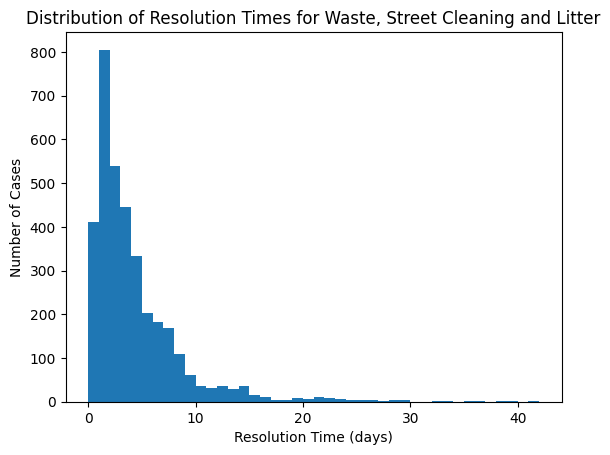

In [91]:
import matplotlib.pyplot as plt

plt.hist(waste_case_source['days_to_complete'], bins = range(min(waste_case_source['days_to_complete']), max(waste_case_source['days_to_complete']) + 1, 1))
plt.title('Distribution of Resolution Times for Waste, Street Cleaning and Litter')
plt.xlabel('Resolution Time (days)')
plt.ylabel('Number of Cases')
plt.show()

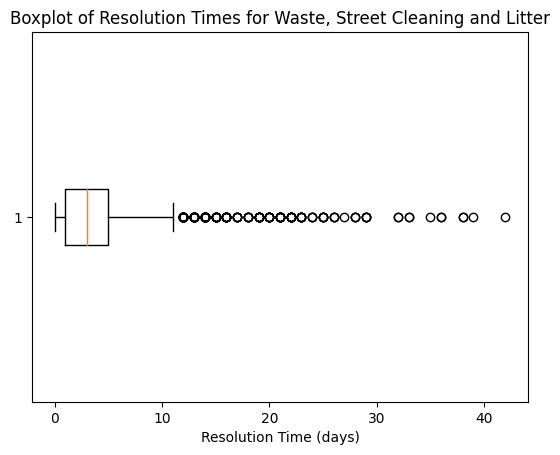

In [92]:
plt.boxplot(waste_case_source['days_to_complete'], vert = False)
plt.title('Boxplot of Resolution Times for Waste, Street Cleaning and Litter')
plt.xlabel('Resolution Time (days)')
plt.show()

In [93]:
# calculate basic descriptive statistics
desc_stats = waste_case_source['days_to_complete'].describe()

# calculate skewness and kurtosis
skewness = waste_case_source['days_to_complete'].skew()
kurtosis = waste_case_source['days_to_complete'].kurt()

print(desc_stats)
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

count      3538.0
mean     3.866591
std       4.49971
min           0.0
25%           1.0
50%           3.0
75%           5.0
max          42.0
Name: days_to_complete, dtype: Float64
Skewness: 2.9401499151196453
Kurtosis: 12.794757554245257


*The data suggest that the service for 'Waste, Street Cleaning and Litter' is quite efficient, with most cases being resolved in a short time frame. There are some cases that take much longer to resolve, which could be due to more complex issues or other factors that impede quick resolution.*

*Given the right skew and presence of outliers, the median is a more reliable measure of central tendency for this data. It indicates that a typical case is resolved in 3 days. The high kurtosis value implies that the process has occasional cases that are far from the norm. These may warrant further investigation to understand the reasons for such delays and to identify any potential improvements in service delivery.*

***Resolution time by 'case_origin'***

*Compare the resolution times ('days_to_complete') across different case origins to see if some channels experience faster or slower resolution times, which may indicate efficiency or accessibility issues.*

In [94]:
# count the number of cases by case origin
waste_case_source_dist = waste_case_source['case_origin'].value_counts()

waste_case_source_dist

case_origin
Phone              1518
Web                1096
Proactive           439
Snap Send Solve     425
Email                46
Face-to-Face          8
SMS                   3
Live Chat             3
Name: count, dtype: int64

In [95]:
# calculate the median resolution time by case origin
waste_res_time_by_origin = waste_case_source.groupby('case_origin')['days_to_complete'].median().reset_index()

# sort the DataFrame by 'days_to_complete' to order the bars in the bar chart
waste_res_time_by_origin = waste_res_time_by_origin.sort_values(by = 'days_to_complete')

waste_res_time_by_origin

,case_origin,days_to_complete
2,Live Chat,0.0
4,Proactive,1.0
3,Phone,2.0
0,Email,2.5
6,Snap Send Solve,3.0
7,Web,3.0
5,SMS,4.0
1,Face-to-Face,4.5


In [96]:
# merge with the case origin count data
waste_res_time_by_origin = pd.merge(waste_res_time_by_origin, waste_case_source_dist, on = 'case_origin')

In [97]:
# plt.barh(resolution_time_by_origin['case_origin'], resolution_time_by_origin['days_to_complete'])
# plt.xlabel('Median Resolution Time (days)')
# plt.ylabel('Case Origin')
# plt.title('Median Resolution Time by Case Origin for Waste Category')
# plt.tight_layout()  # ensures that all labels and titles are visible
# plt.show()

In [98]:
import plotly.graph_objects as go

# creating table with Plotly

# define header and cells content for the table
header_values = ["Case Origin", "Median Resolution Time (days)", "Case Volume"]
cell_values = [waste_res_time_by_origin['case_origin'],
               waste_res_time_by_origin['days_to_complete'],
               waste_res_time_by_origin['count']
               ]

# create table figure
fig_table = go.Figure(data = [go.Table(
    header = dict(values = header_values, fill_color = 'paleturquoise', align = 'left'),
    cells = dict(values = cell_values, fill_color = 'lavender', align = 'left')
    )])

fig_table.update_layout(
    title = 'Case Volume and Median Resolution Time by Case Origin for Waste Category'
)

# show
fig_table.show()

*The table reveals that digital and proactive channels generally offer quicker resolutions, which may encourage further investment in these areas to improve service efficiency. In contrast, traditional and in-person channels, while still important, appear to be slower and may require a review of operational processes. Understanding the reasons behind the varying median resolution times and case volumes can inform strategic decisions to enhance overall service delivery and customer satisfaction.*

## Bar chart

In [99]:
# filter data
res_time_by_category = df[(df['days_to_complete'].notnull())].sort_values(by = ['date_received'])

res_time_by_category.head(2)

,status,date_received,date_completed,suburb,category,service_type,days_to_complete,case_origin,rec_year,rec_month
0,Closed,2014-11-10,2014-11-11,Kensington,"Waste, Street Cleaning and Litter",Public Litter Bin,1,Unknown,2014,11
51,Closed,2014-11-10,2014-11-12,Unknown,"Waste, Street Cleaning and Litter",Illegally Dumped Rubbish,2,Unknown,2014,11


In [100]:
# # boxplot
# fig_category = px.box(df, x = 'category', y = 'days_to_complete',
#                       title = "Distribution of Resolution Times by Category",
#                       color = 'category')

# fig_category.update_layout(
#     xaxis_title = "Category",
#     yaxis_title = "Resolution Time (days)",
#     xaxis = {'categoryorder':'total descending'},
#     autosize = True,
#     width = 1200,
#     height = 600,
#     margin = dict(l = 40, r = 40, b = 80, t = 100),
# )

# fig_category.update_xaxes(tickangle = 45)

# fig_category.show()

In [101]:
# calculate median resolution times for each category
median_res_time_by_category = res_time_by_category.groupby('category')['days_to_complete'].median().reset_index()

# Create a bar chart
fig_bar = px.bar(median_res_time_by_category, x = 'category', y = 'days_to_complete',
                 title = "Median Resolution Times by Category")

fig_bar.update_layout(
    xaxis_title = "Category",
    yaxis_title = "Median Resolution Time (days)",
    autosize = False,
    width = 1200,
    height = 600,
    margin = dict(l = 40, r = 40, b = 80, t = 100),
)

fig_bar.update_xaxes(tickangle = 45)

fig_bar.show()

## Stacked bar chart

In [102]:
# filter the DataFrame for records with known resolution times and case origins
# and aggregate the data for each category and channel
volume_by_channel_category = df[(df['case_origin'] != 'Unknown') & (df['days_to_complete'].notna())]
volume_by_channel_category = volume_by_channel_category.groupby(['category', 'case_origin']).size().reset_index(name = 'volume')

volume_by_channel_category.head(2)

,category,case_origin,volume
0,General,Email,1078
1,General,Face-to-Face,3


In [103]:
# create a grouped bar chart using Plotly
fig = px.bar(volume_by_channel_category, x = 'category', y = 'volume', color = 'case_origin',
             title = 'Volume of Contacts by Channel and Category for 2018',
             labels = {'volume': 'Volume of Contacts', 'case_origin': 'Communication Channel'},
             category_orders = {"category": volume_by_channel_category['category'].unique().tolist()})

# show the figure
fig.show()

*The 'General' category displays the largest volume of contacts across almost all channels, which suggests it covers a diverse range of issues or inquiries. This trend may indicate the need for increased focus and resources to manage customer inquiries effectively.*

*The 'Web' and 'Phone' channels enjoy widespread popularity across all categories, reflecting a preference for digital and voice communication in addressing these matters.*

*'Face-to-Face', 'Live Chat', and 'SMS' are less frequently utilized channels across all categories, which could signal a tendency towards more traditional or straightforward forms of communication.*

*The 'Proactive' and 'Snap Send Solve' channels appear to be uniquely employed in certain categories, such as 'General' and 'Graffiti'. This specificity could point to targeted campaigns or initiatives designed to address issues pertinent to these categories.*

*The absence of categories such as 'Asset maintenance' and 'Roads and Traffic' from the data may necessitate an investigation to confirm there are no issues with data recording and to ensure that these channels are being properly monitored and reported. If this is a case of missing data, it underscores the importance of consistent data capture across all service categories to facilitate a comprehensive analysis.*

## Clustered bar chart

In [104]:
# group by category and case_origin and calculate the median resolution time
res_time_by_channel_category = df[(df['case_origin'] != 'Unknown') & (df['days_to_complete'].notna())]
res_time_by_channel_category = res_time_by_channel_category.groupby(['category', 'case_origin'])['days_to_complete'].median().reset_index()

# create a grouped bar chart
fig = px.bar(res_time_by_channel_category,
             x = 'category',
             y = 'days_to_complete',
             color = 'case_origin',
             barmode = 'group',
             title = 'Median Resolution Time by Channel and Category for 2018',
             labels = {'days_to_complete': 'Median Resolution Time (days)', 'case_origin': 'Communication Channel'})

# show the plot
fig.show()

## Dot plot

In [116]:
fig_dotplot = px.scatter(res_time_by_channel_category, x = 'days_to_complete', y = 'category', color = 'case_origin',
                 title = "Median Resolution Time by Channel and Category",
                 labels = {'days_to_complete': 'Median Resolution Time (days)', 'case_origin': 'Communication Channel'})

# increase the marker size
fig_dotplot.update_traces(marker = dict(size = 10))

# customize figure layout
fig_dotplot.update_layout(
    xaxis_title = 'Median Resolution Time (days)',
    yaxis_title = 'Category',
    yaxis = {'categoryorder': 'total ascending'},
    legend_title_text = 'Communication Channel'
)

# show
fig_dotplot.show()

*There is a noticeable variation in resolution times across different communication channels within the same category. The absence of resolution days for certain channels may imply no activity, pointing to the possibility that the choice of communication method can significantly influence the promptness of issue resolution.*

*The 'Web' and 'Mail' channels exhibit high median resolution times within the 'General' category, which may suggest a backlog in case handling or inherently slower processes associated with these request types.*

*In the 'Waste' category, resolution times are notably uniform across channels, indicating a potentially standardized approach to responding to these issues.*

*Conversely, the 'Phone' and 'Snap Send Solve' channels demonstrate relatively lower median resolution times across most categories, alluding to greater efficiency in these communication forms. Specifically, the 'SMS' channel shows expedited resolution in the 'Parking' category, which suggests that text messaging may facilitate faster problem-solving. On the other hand, the 'Mail' channel's extended resolution times across various categories could stem from the natural delays in postal delivery or the time needed to process mailed requests.*

*Overall, the data indicates that digital and instantaneous communication methods, such as 'Phone', 'Live Chat', and 'Snap Send Solve', are associated with quicker resolution times, whereas traditional methods like 'Mail' and 'Web' tend to require longer periods.*

*It's noteworthy that the 'Parking' category primarily utilizes web and phone channels for service requests, which is correlated with a highly efficient resolution time—median days to completion is at zero for these channels.*

*However, the 'General' category tells a different story; it receives the bulk of its requests via web and mail, followed by email. Interestingly, these channels are associated with the longest durations for case resolution.*

*An intriguing observation from the stacked bar chart is the scant usage of mail for reporting graffiti, which may be attributable to it having the longest resolution time among all communication channels.*

*Another compelling insight is the even distribution of service requests within the 'Waste' category across various channels, paralleled by uniform resolution times. This consistency suggests an efficient, standardized process for handling waste-related services, regardless of the communication method.*